In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.fft
from scipy.special import factorial
import math
# import csv
from matplotlib import rc, rcParams

def fitlin(x, y, sig):
    '''
    Performs a least-squares linear fit

    Parameters
    ----------
    x : array
        The independent data
    y : array
        The dependent data
    sig : array
        The uncertainty in y

    Returns
    ----------
    popt : array
        Optimal values for the parameters
    perr : array
        The uncertainty on the fit parameters
    chisq : float
        The value of chi-squared
    yfit : array
        The values of the fitted line at each x
    '''

    ### See Bevington and Robinson Ch. 6 (p. 114)

    # TLDR: by minimizing the chi-squared, you get a system of equations
    ###         term3 = b * term1 + m * term5
    ###         term4 = b * term5 + m * term2
    ###     this equation can be solved by taking determinants
    ###     the inverse of the matrix (the curvature matrix of a linear ftn)
    ###         ( term1 term5 )
    ###         ( term5 term2 )
    ###     is the covariance matrix, and the diagonal terms are the fit errors
    ###     the full formulas can be found on page 114 of Bevington

    term1 = np.sum(    1 / sig**2 )
    term2 = np.sum( x**2 / sig**2 )
    term3 = np.sum(    y / sig**2 )
    term4 = np.sum(  x*y / sig**2 )
    term5 = np.sum(    x / sig**2 )

    delta = term1*term2 - term5**2

    b = ( term2*term3 - term5*term4 ) / delta
    m = ( term1*term4 - term5*term3 ) / delta
    popt = np.array([b, m])

    berr = np.sqrt( term2 / delta )
    merr = np.sqrt( term1 / delta )
    perr = np.array([berr, merr])

    yfit = b + m*x

    chisq = np.sum( ( (y - yfit) / sig )**2 )

    return popt, perr, chisq, yfit

In [4]:
floating_brownian_stem = 'data/Real/'
floating_brownian_suffix = 'mA_20k_10s_3u_10-29' # has _2 or just .txt
laser_powers = [100.6, 193.2, 293.2, 392.6, 493.1]
laser_power_strs = [str(power).split(".") for power in laser_powers]
dirs = ['_'.join(tup) for tup in laser_power_strs]
file_starts = ['-'.join(tup) for tup in laser_power_strs]
floating_brownian_files = [floating_brownian_stem + dirs[i] + '/' + file_starts[i] + floating_brownian_suffix for i in range(len(laser_powers))]
floating_brownian_files = [(floating_brownian_files[0] + ".txt",)] + [(file_name + ".txt", file_name + "_2.txt") for file_name in floating_brownian_files[1:]]
print(floating_brownian_files)

[('data/Real/100_6/100-6mA_20k_10s_3u_10-29.txt',), ('data/Real/193_2/193-2mA_20k_10s_3u_10-29.txt', 'data/Real/193_2/193-2mA_20k_10s_3u_10-29_2.txt'), ('data/Real/293_2/293-2mA_20k_10s_3u_10-29.txt', 'data/Real/293_2/293-2mA_20k_10s_3u_10-29_2.txt'), ('data/Real/392_6/392-6mA_20k_10s_3u_10-29.txt', 'data/Real/392_6/392-6mA_20k_10s_3u_10-29_2.txt'), ('data/Real/493_1/493-1mA_20k_10s_3u_10-29.txt', 'data/Real/493_1/493-1mA_20k_10s_3u_10-29_2.txt')]


In [11]:
data = []
for power_tuple in floating_brownian_files:
    power_data = []
    for trial_file in power_tuple:
        with open(trial_file, mode ='r') as file:
            lines = file.readlines()
            power_data += [[[float(i) for i in line.split("\t")] for line in lines]]

    data += [np.array(power_data)]

0.06547369814849414 0.26771495720499383


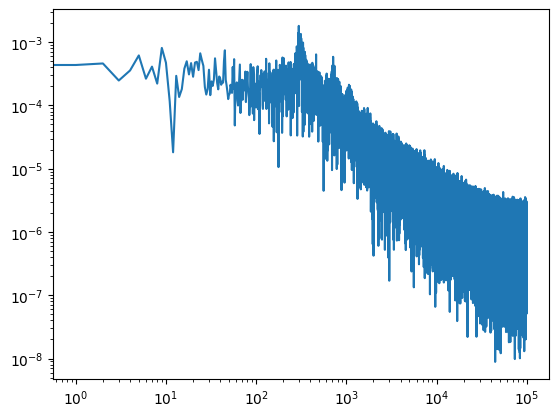

0.18250516159500954 0.16594918080500756


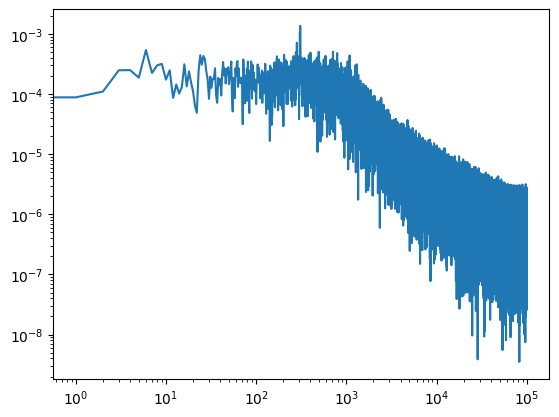

0.18397481681301128 0.1652781797100045


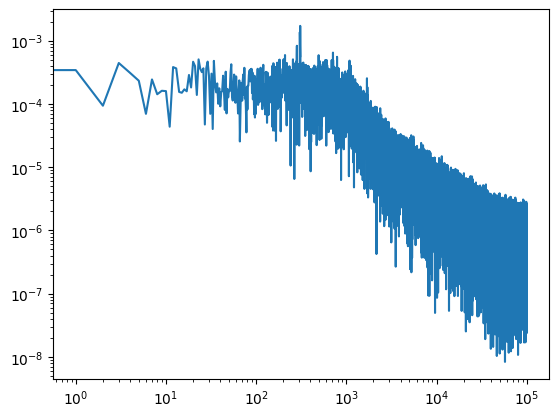

0.3285651867505393 0.34814013677500844


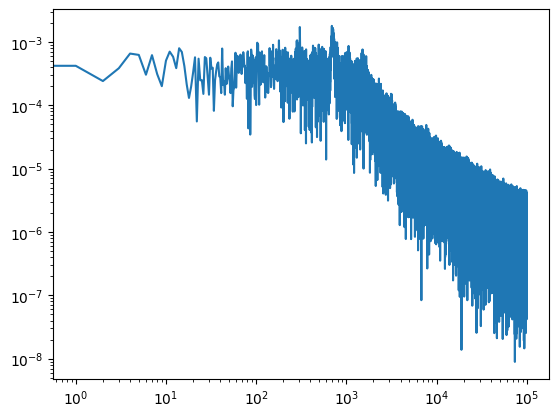

0.33075684455500104 0.3230002390299779


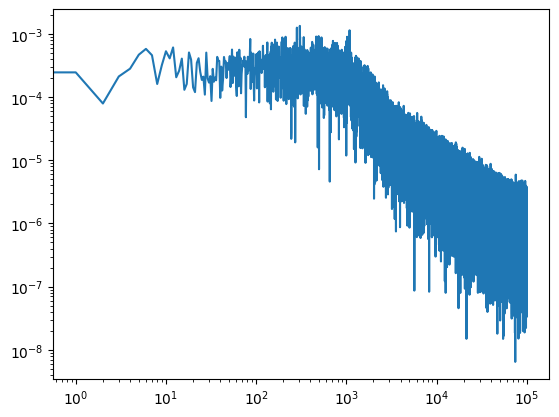

0.47977419052500325 0.5188163631200163


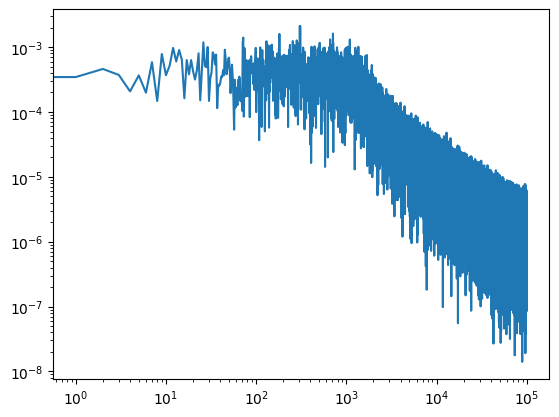

0.46343767259500035 0.515296755840005


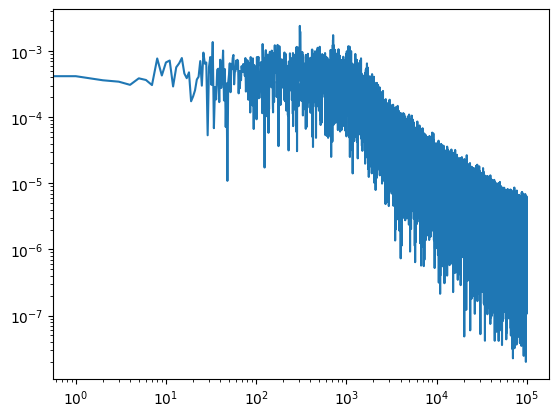

0.6076066497470983 0.5415833099449956


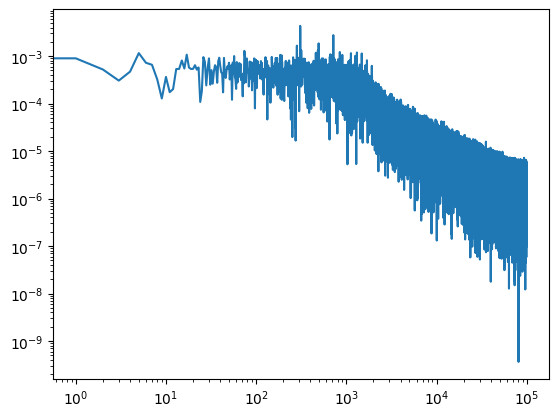

0.593918984680013 0.5906270542950246


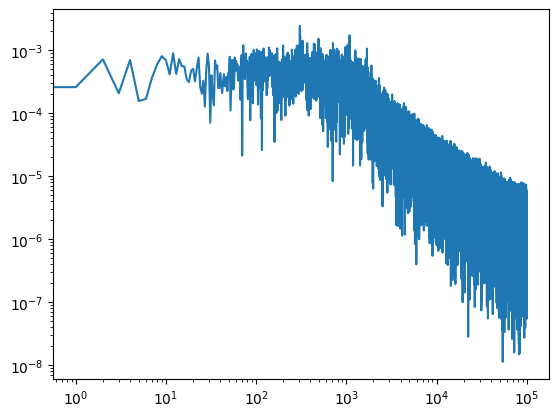

In [17]:
for power_tuple in data:
    for trial_data in power_tuple:
        # plt.plot(trial_data[:,0], trial_data[:,1], lw=0.1)
        # plt.show()
        avgx = sum(trial_data[:,0] / len(trial_data))
        avgy = sum(trial_data[:,1] / len(trial_data))
        print(avgx, avgy)

        dists = np.sqrt((trial_data[:,0] - avgx) ** 2 + (trial_data[:,1] - avgy) ** 2)
        freqs = scipy.fft.fft(dists) / len(dists)
        plt.loglog(abs(freqs[100:10**5]))
        plt.show()